In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import pandas as pd
from gensim.models import FastText
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
BASE_PATH = "/content/gdrive/MyDrive/fyp-2018/exps/MicrosoftBigMalware"

In [ ]:
classes = [i for i in range(1, 10)]
class_id_to_name = {
    1: "Ramnit",
    2: "Lollipop",
    3: "Kelihos_ver3",
    4: "Vundo",
    5: "Simda",
    6: "Tracur",
    7: "Kelihos_ver1",
    8: "Obfuscator.ACY",
    9: "Gatak"
}

In [ ]:
def make_corpus(class_id):
    class_docs = []
    with open(BASE_PATH + f"/malware-classification-opcode-extract/whole-dataset-opcodes/{class_id}/parsed_opcodes.txt") as openfile:
        for line in openfile.readlines():
            _, opcodes = line.split(":")
            opcodes = opcodes.strip()
            opcodes = opcodes.split(",")
            opcodes = [opcode.strip() for opcode in opcodes]
            class_docs.append(opcodes)
    return class_docs

In [ ]:
corpus_dict = {class_id: make_corpus(class_id) for class_id in classes}

In [ ]:
# model = FastText(min_count=1, size=100, sg=0)
# model.build_vocab(sentences=sents)
# model.train(sents, total_examples=len(sents), epochs=100 )

In [ ]:
# model.save(BASE_PATH + "/models_w2v/fast_text.bin")
model = FastText.load(BASE_PATH + "/models_w2v/fast_text.bin")

In [ ]:
print(model.corpus_count)
print(model.corpus_total_words)

1223
16784206


In [ ]:
model.wv.most_similar("push")[:5]

[('pop', 0.96063232421875),
 ('sub', 0.39044177532196045),
 ('retn', 0.347350150346756),
 ('ror', 0.26974236965179443),
 ('rcr', 0.1784888505935669)]

In [ ]:
model.wv.most_similar("mov")[:5]

[('movsw', 0.9830729961395264),
 ('movsb', 0.9379875659942627),
 ('nop', 0.3643956482410431),
 ('int', 0.17793148756027222),
 ('not', 0.14001122117042542)]

In [ ]:
model.wv.most_similar("add")[:5]

[('stc', 0.08141594380140305),
 ('sub', 0.07580248266458511),
 ('ror', 0.06466327607631683),
 ('das', 0.0030140429735183716),
 ('hlt', 0.0026539750397205353)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


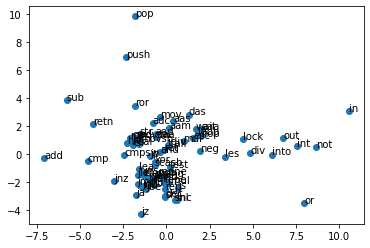

In [ ]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
results = pca.fit_transform(X)

plt.scatter(results[:, 0], results[:, 1])
codes = list(model.wv.vocab)
for idx, code in enumerate(codes):
    plt.annotate(code, xy=(results[idx, 0], results[idx, 1]))
plt.show()

## Ideas for document vectors:
- Average of token vectors

In [ ]:
def get_doc_vector(doc_tokens, embed_size=100):
    doc_vec = np.zeros((1, embed_size), dtype=np.float64)
    for token in doc_tokens:
        try:
            doc_vec += model.wv.get_vector(token)
        except KeyError:
            pass
    doc_vec /= len(doc_tokens)
    return doc_vec

def get_class_vectors(docs, embed_size=100):
    class_vectors = np.zeros((len(docs), embed_size), dtype=np.float64)
    for idx, doc_tokens in enumerate(docs):
        class_vectors[idx, :] = get_doc_vector(doc_tokens)

    return class_vectors

doc_vector_dict = {}
for k, v in corpus_dict.items():
    doc_vector_dict[k] = get_class_vectors(v)
    print(doc_vector_dict[k].shape)

(1541, 100)
(2478, 100)
(2942, 100)
(475, 100)
(42, 100)
(751, 100)
(398, 100)
(1228, 100)
(1013, 100)


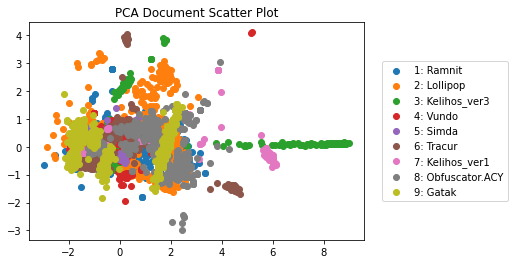

In [ ]:
for k, v in doc_vector_dict.items():
    projections = pca.fit_transform(v)
    plt.scatter(projections[:, 0], projections[:, 1], label=f"{k}: {class_id_to_name[k]}")

plt.title("PCA Document Scatter Plot")
plt.legend(loc="center left", bbox_to_anchor=(1.04, 0.5))
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default lea

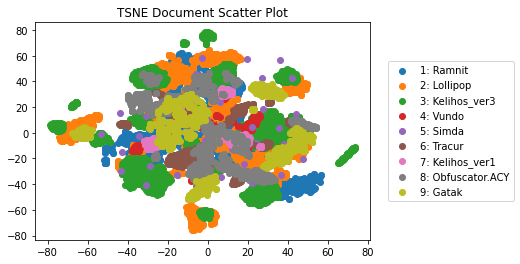

In [ ]:
tsne = TSNE(n_components=2)

for k, v in doc_vector_dict.items():
    projections = tsne.fit_transform(v)
    plt.scatter(projections[:, 0], projections[:, 1], label=f"{k}: {class_id_to_name[k]}")

plt.title("TSNE Document Scatter Plot")
plt.legend(loc="center left", bbox_to_anchor=(1.04, 0.5))
plt.show()